# Raw data analisys 

As part of the preprocessing, a quick check of the raw data downloaded from ChEMBL is going to be carried out. 

In this section we will analize the difference between the molecules label as actives or inactive in the column "Comment". 

In [1]:
import pandas as pd
pd.options.display.max_columns = None

## Data downloaded from ChEMBL 

As the data presented in the contest did not have all columns. Direct download from ChEMBL was carried out searching for "Beta-lactamase AmpC" as the target. The downloaded file was saved as *molecule_activity* 

In [2]:
df = pd.read_csv('./molecule_activity.csv',sep=';')
df.columns[0:20]

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI'],
      dtype='object')

As we can see, there is a columns called "Comment" which is describes as:

*"Activity comments may provide the overall activity conclusions from the data depositor (e.g. toxic, non-toxic, active, inactive) after taking into account other factors such as counter screens. This can explain cases where compounds with apparently potent activities are flagged as inactive/inconclusive."*

From: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions

## My interpretation
This tell us that this comments are good source to distinguish between actives and inactives with more presicion.

## Split of the data set into 3 categories: 

The main idea is to subtract from the undefined set, the molecules that are active or inactive not using an arbitrary pChEMBL value cutoff. As I found in some ChEMBL preprocessing pipelines, the column *Comment* is used as a first criteria to split the data, so in this case the comments used were: 

* Actives
* Inactives
* Inconclusive

Papers using this aproach:
<div class="csl-entry">Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., Clevert, D. A., &#38; Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <i>Chemical Science</i>, <i>9</i>(24), 5441–5451. https://doi.org/10.1039/C8SC00148K</div>

In [this paper](https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31) the autors did not use the ambiguos results of the HTS study.

https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31


In [3]:
df.Comment.value_counts().head(10)

Inconclusive               52677
Not Active                  8951
Active                       165
Not Determined                 7
Not applicable                 4
Hydrolysis not detected        2
324165                         1
324147                         1
324209                         1
324191                         1
Name: Comment, dtype: int64

As we can see, the most repeated values are Inconclusive, Not active, and Active ones. The rest of the values are going to be deleted from the data set since they are ambiguous. 
First, we are going to analysis the values of the actives and inactive in the same data frame. 

In [4]:
df_inconclusive = df[(df.Comment == 'Inconclusive')]
df_act_inac = df[(df.Comment == 'Active') | (df.Comment == 'Not Active')]

## pChEMBL value in the active and inactive sets
As the value of the pChEMBL was proposed as the main distintion for active molecules and inactives, it would be pertinet to actually check if it is a good idea.

In [6]:
# By counts
df_count = df_act_inac.groupby(['Standard Type', 'Comment']).count()[['pChEMBL Value', 'Standard Value']]
# By mean
df_mean = df_act_inac.groupby(['Standard Type', 'Comment']).mean()[['pChEMBL Value', 'Standard Value']]
# By std
df_std = df_act_inac.groupby(['Standard Type', 'Comment']).std()[['pChEMBL Value', 'Standard Value']]

### Count grouping by 'Standard Type' and 'Comment'

In [7]:
df_count

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active              0               0
Inhibition    Not Active              0               0
Ki            Active                  8               8
No change     Not Active              0               0
Potency       Active                157             157
              Not Active           8886            8886

Active/Inactive molecules are only present in the Potency Standard value, which is a general representation of the activity. It would be desirable build a dataset based only in one ST but only potency is available. There are also active molecules for the Ki ST but are only 8. Those will be considered in the dataset. 

### Mean grouping by 'Standard Type' and 'Comment'

In [13]:
df_mean

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           4.895000    13500.000000
No change     Not Active            NaN             NaN
Potency       Active           4.601975    37869.515924
              Not Active       4.978202    37462.626052

This part goes interesting, since the mean value in both datasets have very similar pChEMBL values for the active and inactive molecules, but what is weird is that the mean of inactive molecules is higher than the mean of active ones. That means that pChEMBL value is not that reliable to distinguish between actives and inactives. To make this more visual, there will be presented the histogram for the pChEMBL value for each dataset. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df_act = df_act_inac[df_act_inac['Comment'] == 'Active']
df_inact = df_act_inac[df_act_inac['Comment'] == 'Not Active']

df_act_counts = df_act.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_inact_counts = df_inact.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_act_counts.columns = ['pChEMBL Value', 'Relative Count']
df_inact_counts.columns = ['pChEMBL Value', 'Relative Count']

# Standarizing
df_act_counts['Relative Count'] = (df_act_counts['Relative Count'] / df_act_counts['Relative Count'].sum()) * 100
df_inact_counts['Relative Count'] = (df_inact_counts['Relative Count'] / df_inact_counts['Relative Count'].sum()) * 100

#### Actives

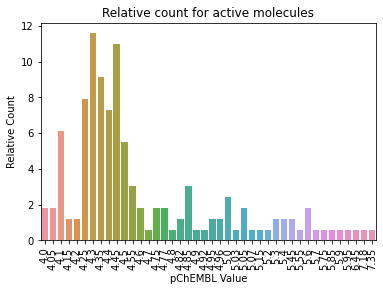

In [9]:
sns.barplot(x = df_act_counts['pChEMBL Value'], y = df_act_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for active molecules')
plt.show()

Text(0.5, 1.0, 'Counts for active molecules')

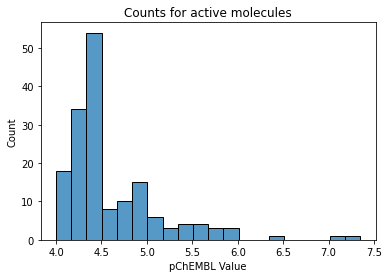

In [10]:
sns.histplot(df_act['pChEMBL Value'], bins=20)
plt.title('Counts for active molecules')

Its important to note that a big quantity of the pChEMBL values for active molecules are low, being almost half of the records between 4.25 and 5.0.

#### Inactives

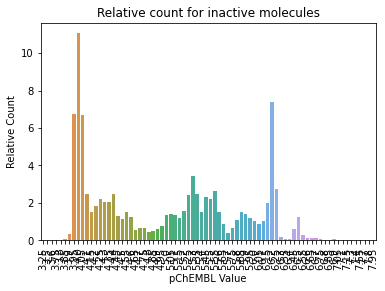

In [11]:
sns.barplot(x = df_inact_counts['pChEMBL Value'], y = df_inact_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for inactive molecules')
plt.show()

Text(0.5, 1.0, 'Counts for inactive molecules')

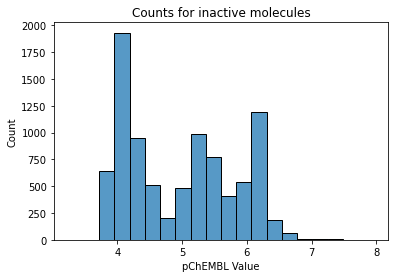

In [12]:
sns.histplot(df_inact['pChEMBL Value'], bins=20)
plt.title('Counts for inactive molecules')


Also the inactives molecules have many molecules with high pChEMBL value.

#### Inconclusive

Text(0.5, 1.0, 'Counts for inconclusive molecules')

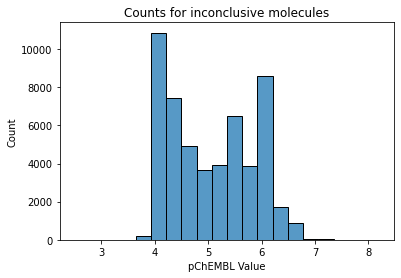

In [13]:
sns.histplot(df_inconclusive['pChEMBL Value'], bins=20)
plt.title('Counts for inconclusive molecules')

In the inconclusive values, there is not clear bias in the pChEMBL value, that is ok, since it represents a pool of possible active/inactive values. 
As a conclusion, there is not clear difference in pChEMBL value between active and inactive molecules since all distributions looks centered. 

### Std grouping by 'Standard Type' and 'Comment'

In [14]:
df_std

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           0.178646     4140.393356
No change     Not Active            NaN             NaN
Potency       Active           0.550129    23917.411609
              Not Active       0.849518    42650.491602

## Saving the dataframes in different csv files

First, we are going to select the columns that are going to be usefull in the future

In [26]:
columns = ['Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'BAO Label', 'Target Name']
columns_desired_name = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'pChEMBL_Value', 'BAO_Label', 'Target_Name']

df_act = df_act[columns]
df_inact = df_inact[columns]
df_inconclusive = df_inconclusive[columns]

df_act.columns = columns_desired_name
df_inact.columns = columns_desired_name
df_inconclusive.columns = columns_desired_name

Now we save the dataframes in diferent files

In [17]:
df_act.to_csv('./actives.csv', index=False)
df_inact.to_csv('./inactives.csv', index=False)
df_inconclusive.to_csv('./inconclusive.csv', index=False)

## Analyzing some molecule properties between molecules datasets

Part of the code was taken from the book: 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [29]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 
import numpy as np

%matplotlib inline

In [27]:
df_act = df_act[['Smiles', 'pChEMBL_Value']]
df_inact = df_inact[['Smiles', 'pChEMBL_Value']]
df_inconclusive = df_inconclusive[['Smiles', 'pChEMBL_Value']]

In [32]:
def molFromSmiles(smiles):
    if isinstance(smiles, str):
        return Chem.MolFromSmiles(smiles)
    else:
        return False
    
def wtFromMol(mol):
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return 0
    
def MolLogP(mol):
    if mol:
        return Descriptors.MolLogP(mol)
    else:
        return 0
    
def GetFormalCharge(mol):
    if mol:
        return rdmolops.GetFormalCharge(mol)
    else:
        return 0

def add_property_columns_to_df(df_in):
    df_in['MW'] = [wtFromMol(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["logP"] = [MolLogP(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["charge"] = [GetFormalCharge(molFromSmiles(smiles)) for smiles in df_in.Smiles]


In [33]:
add_property_columns_to_df(df_act)
add_property_columns_to_df(df_inact)
add_property_columns_to_df(df_inconclusive)

In [36]:
df_act = df_act.assign(status='Active')
df_inact = df_inact.assign(status='Inactive')

df_act_inac = pd.concat([df_act, df_inact]).sample(frac=1).sample(frac=1).sample(frac=1)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='MW'>

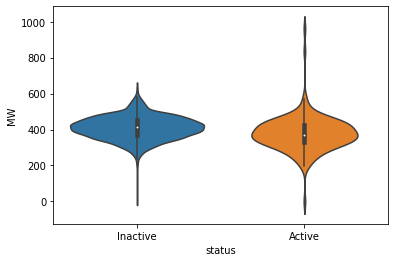

In [37]:
sns.violinplot(df_act_inac["status"],df_act_inac["MW"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='logP'>

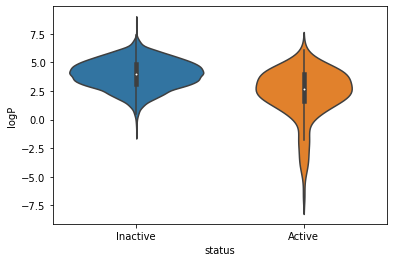

In [38]:
sns.violinplot(df_act_inac["status"],df_act_inac["logP"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='charge'>

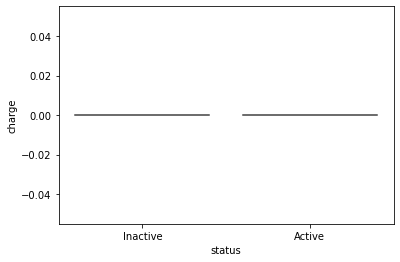

In [39]:
sns.violinplot(df_act_inac["status"],df_act_inac["charge"])

Molecule properties will be revised again at the end of the preprocess

# Basic filtering
In this section, a basic filtering, standardization, and aggregation of duplicates by dataset is going to be carried out. After that, a rd_filter is going to be applied. 

In [4]:
import pandas as pd
import numpy as np

## Reading of files in different dataframes

In [6]:
df_act = pd.read_csv('./raw_data/actives.csv')
df_inact = pd.read_csv('./raw_data/inactives.csv')
df_inc = pd.read_csv('./raw_data/inconclusive.csv')
df_act

,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,BAO_Label,Target_Name
0,Cc1cc(C)n(C(=O)CSc2nc3ccccc3o2)n1,Potency,'=',28183.8,nM,4.55,assay format,Beta-lactamase AmpC
1,CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(...,Potency,'=',5011.9,nM,5.30,assay format,Beta-lactamase AmpC
2,Nc1nc2c(s1)CCc1c-2cnn1-c1ccccc1,Potency,'=',89125.1,nM,4.05,assay format,Beta-lactamase AmpC
3,CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...,Potency,'=',1800.0,nM,5.75,assay format,Beta-lactamase AmpC
4,CO[C@@]1(NC(=O)C2SC(=C(C(N)=O)C(=O)O)S2)C(=O)N...,Potency,'=',17782.8,nM,4.75,assay format,Beta-lactamase AmpC
...,...,...,...,...,...,...,...,...
160,N#C/C(C(=O)Nc1ccc(Cl)cc1)=C(/S)Nc1ccccc1,Potency,'=',39810.7,nM,4.40,assay format,Beta-lactamase AmpC
161,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,Potency,'=',63095.7,nM,4.20,assay format,Beta-lactamase AmpC
162,O=C1c2ccccc2C(=O)N1OS(=O)(=O)c1ccccc1,Potency,'=',44668.4,nM,4.35,assay format,Beta-lactamase AmpC
163,Cn1cnnc1SCC(=O)Nc1nc(-c2ccccc2)cs1,Potency,'=',79432.8,nM,4.10,assay format,Beta-lactamase AmpC


## Main filtering
This filtering is going to select:
1. 'Target_Name' == 'Beta-lactamase AmpC'
2. 'BAO_Label' == 'assay format'
3. 'Standard_Relation' == '='
4. 'Standard_Type' == 'IC50') | 'Potency' | 'Ki')

Then a filtering searching for delete mising values on Smiles and pChEMBL_Value columns

In [7]:
df_act_fil = main_filtering(df_act, 'Actives')
df_inact_fil = main_filtering(df_inact, 'Inactives')
df_inc_fil = main_filtering(df_inc, 'Inconclusives')


= = = = = = = = = = = = = = = =
There are 165 molecules in the Actives dataset before filtering
164
There are 164 molecules in the Actives dataset after filtering
= = = = = = = = = = = = = = = =
There are 8951 molecules in the Inactives dataset before filtering
8884
There are 8884 molecules in the Inactives dataset after filtering
= = = = = = = = = = = = = = = =
There are 52677 molecules in the Inconclusives dataset before filtering
52664
There are 52664 molecules in the Inconclusives dataset after filtering


## Using the rd_filters by Pat Walters to 
This part was done in the bash terminal. An try of code implementation is shown below. 
The program was executed in the *processed* folder. The final output is the file of signature:
* ./procesed/{actives/inactives/inconclusives}/{actives/inactives/inconclusives}_filtered_lactamase.smi

In [9]:
# TODO: Automatizing rd_filters. There may be problems when converting dataframe into a smi file, making the rd_filters dont parce the file

# import subprocess

# datasets = [df_act_fil, df_inact_fil, df_inc_fil]
# dataset_name = ['actives', 'inactives', 'inconclusives']

# for name, dataset in zip(dataset_name, datasets):
#     command_folder = f'mkdir ./procesed/{name}'
#     subprocess.call(command_folder, shell=True)
#     dataset['Smiles'].to_csv(f'./procesed/{name}/{name}_for_rd.smi', sep='\t' , header=False, index=False)
    
#     command_rd_filters = " ".join(['rd_filters', 'filter', '--in', f'./procesed/{name}/{name}_for_rd.smi', '--prefix', 'rd_filtered_lactamase'])
#     subprocess.call(command_rd_filters, shell=True)


---

# Supplementary code
Used instead of importing

In [2]:
import pandas as pd
import numpy as np


def basic_filtering(df):
    target_pref_name = (df['Target_Name'] == 'Beta-lactamase AmpC')
    bao_label = df['BAO_Label'] == 'assay format'
    standard_relation = df['Standard_Relation'] == "'='"
    standard_type = (df['Standard_Type'] == 'IC50') | (
        df['Standard_Type'] == 'Potency') | (df['Standard_Type'] == 'Ki')

    df_filtered = df[target_pref_name & bao_label & standard_relation &
                     standard_type][['Smiles', 'Standard_Value', 'pChEMBL_Value']]

    # Procedemos ahora a eliminar files con valores perdidos
    smiles_not_null = df_filtered['Smiles'].notnull()
    smiles_not_empty = df_filtered['Smiles'] != ''

    pchembl_value_not_nut = df_filtered['pChEMBL_Value'].notnull()
    pchembl_value_not_empty = df_filtered['pChEMBL_Value'] != ''

    df_without_missing = df_filtered[smiles_not_null &
                                     smiles_not_empty & pchembl_value_not_nut & pchembl_value_not_empty]
    return df_without_missing


def main_filtering(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before filtering')
    df_bf = basic_filtering(df)
    print(
        f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

    return df_bf






# Standarizing the molecules and aggregation
The standarization is a common procedure used in varios pipelines.

In [ ]:
import pandas as pd
import numpy as np


def smiles_standarization(df):
    from rdkit.Chem.MolStandardize import rdMolStandardize

    def cleaning(df_row):
        smile = df_row[0]
        stadarized_smiles = None
        try:
            stadarized_smiles = rdMolStandardize.StandardizeSmiles(smile)
        except:
            print(f'The molecule {smile} is not stadarizable')

        return stadarized_smiles

    df['Smiles'] = df.apply(cleaning, axis='columns').dropna()

    return df


def duplicate_mean_aggregation(df):
    #df = df[['Smiles', 'pChEMBL_Value']]
    df = df.groupby('Smiles', as_index=False).mean()
    return df


# def main_filtering(df, name):
#     print('= = = = = = = = = = = = = = = =')
#     print(
#         f'There are {len(df)} molecules in the {name} dataset before filtering')
#     df_bf = basic_filtering(df)
#     print(
#         f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

#     return df_bf


def standarization_and_aggregation(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before standarization_and_aggregation')
    df_final = duplicate_mean_aggregation(df)
    df_final = smiles_standarization(df_final)

    print(
        f'There are {len(df_final)} molecules in the {name} dataset after standarization_and_aggregation')

    return df_final


if __name__ == '__main__':
    df_act_rd = pd.read_csv('./raw_data/actives.csv')
    df_inact_rd = pd.read_csv('./raw_data/inactives.csv')
    df_inc_rd = pd.read_csv('./raw_data/inconclusive.csv')

    datasets = [df_act_rd, df_inact_rd, df_inc_rd]
    dataset_name = ['actives', 'inactives', 'inconclusives']
    path = './procesed'

    for name, dataset in zip(dataset_name, datasets):
        df_smi = pd.read_csv(
            f'{path}/{name}/{name}_filtered_lactamase.smi', header=None, sep=" ")
        df_smi.columns = ['Smiles', 'MOL_ID']
        df_smi = duplicate_mean_aggregation(df_smi)

        df_csv = pd.read_csv(
            f'{path}/{name}/{name}.csv')[['Smiles', 'Standard_Value', 'pChEMBL_Value']]
        df_csv = duplicate_mean_aggregation(df_csv)

        df_join = pd.merge(df_smi, df_csv, on='Smiles')[
            ['Smiles', 'pChEMBL_Value']]
        dataset = smiles_standarization(df_join)
        dataset.to_csv(f'{path}/{name}/{name}_final.csv', index=False)


# Clustering the data to get new compounds from the inconclusive datapoints
In this section we are goning to cluster the data and try to identify wich of the inconclusive datapoints can be categorizted as actives, inactives or ambiguos (wich at the end will we retired from the dataset).

Part of the code was taken from:
* https://nbviewer.org/gist/iwatobipen/ba0f60842f8ff5414ed6e5cea598a58b

## Importing the modules and the data

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline
rdDepictor.SetPreferCoordGen(True)

In [2]:
df_act = pd.read_csv('./procesed/actives/actives_final.csv')
df_inac = pd.read_csv('./procesed/inactives/inactives_final.csv')
df_inc = pd.read_csv('./procesed/inconclusives/inconclusives_final.csv')

### Quick check to dataframe structure

In [4]:
df_act.head(2)

,Smiles,pChEMBL_Value
0,C/C(Cl)=C/CC1(CN2CCCC2=O)C(=O)NC(=O)NC1=O,4.55
1,CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...,7.18


## Clustering based on a personal criteria
The main idea is to select the molecules from the inconclusives, that are similar to the active molecules but different to molecules marked as inactives. 

In [5]:
def smiles2mol(smiles):
    return Chem.MolFromSmiles(smiles)

def mol2fparr(mol):
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_act])

# INACTIVE
df_inac_2 = df_inac[df_inac['pChEMBL_Value'] <= 4.5]
smiles_inac = df_inac_2.values[:, 0] 
fps_inac = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inac])

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
pseudo_inactives = df_inc['pChEMBL_Value'] <= 4.5
df_inc_2 = df_inc[pseudo_actives]
smiles_inc = df_inc_2.values[:, 0]
fps_inc = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inc])

## Visualizing chemical space

In [7]:
# ACTIVE
pca_act = PCA(n_components=5)
chemicalspace_act = pca_act.fit_transform(fps_act)

# INACTIVE
pca_inac = PCA(n_components=5)
chemicalspace_inac = pca_inac.fit_transform(fps_inac)

# INCONCLUSIVE
pca_inc = PCA(n_components=5)
chemicalspace_inc = pca_inc.fit_transform(fps_inc)

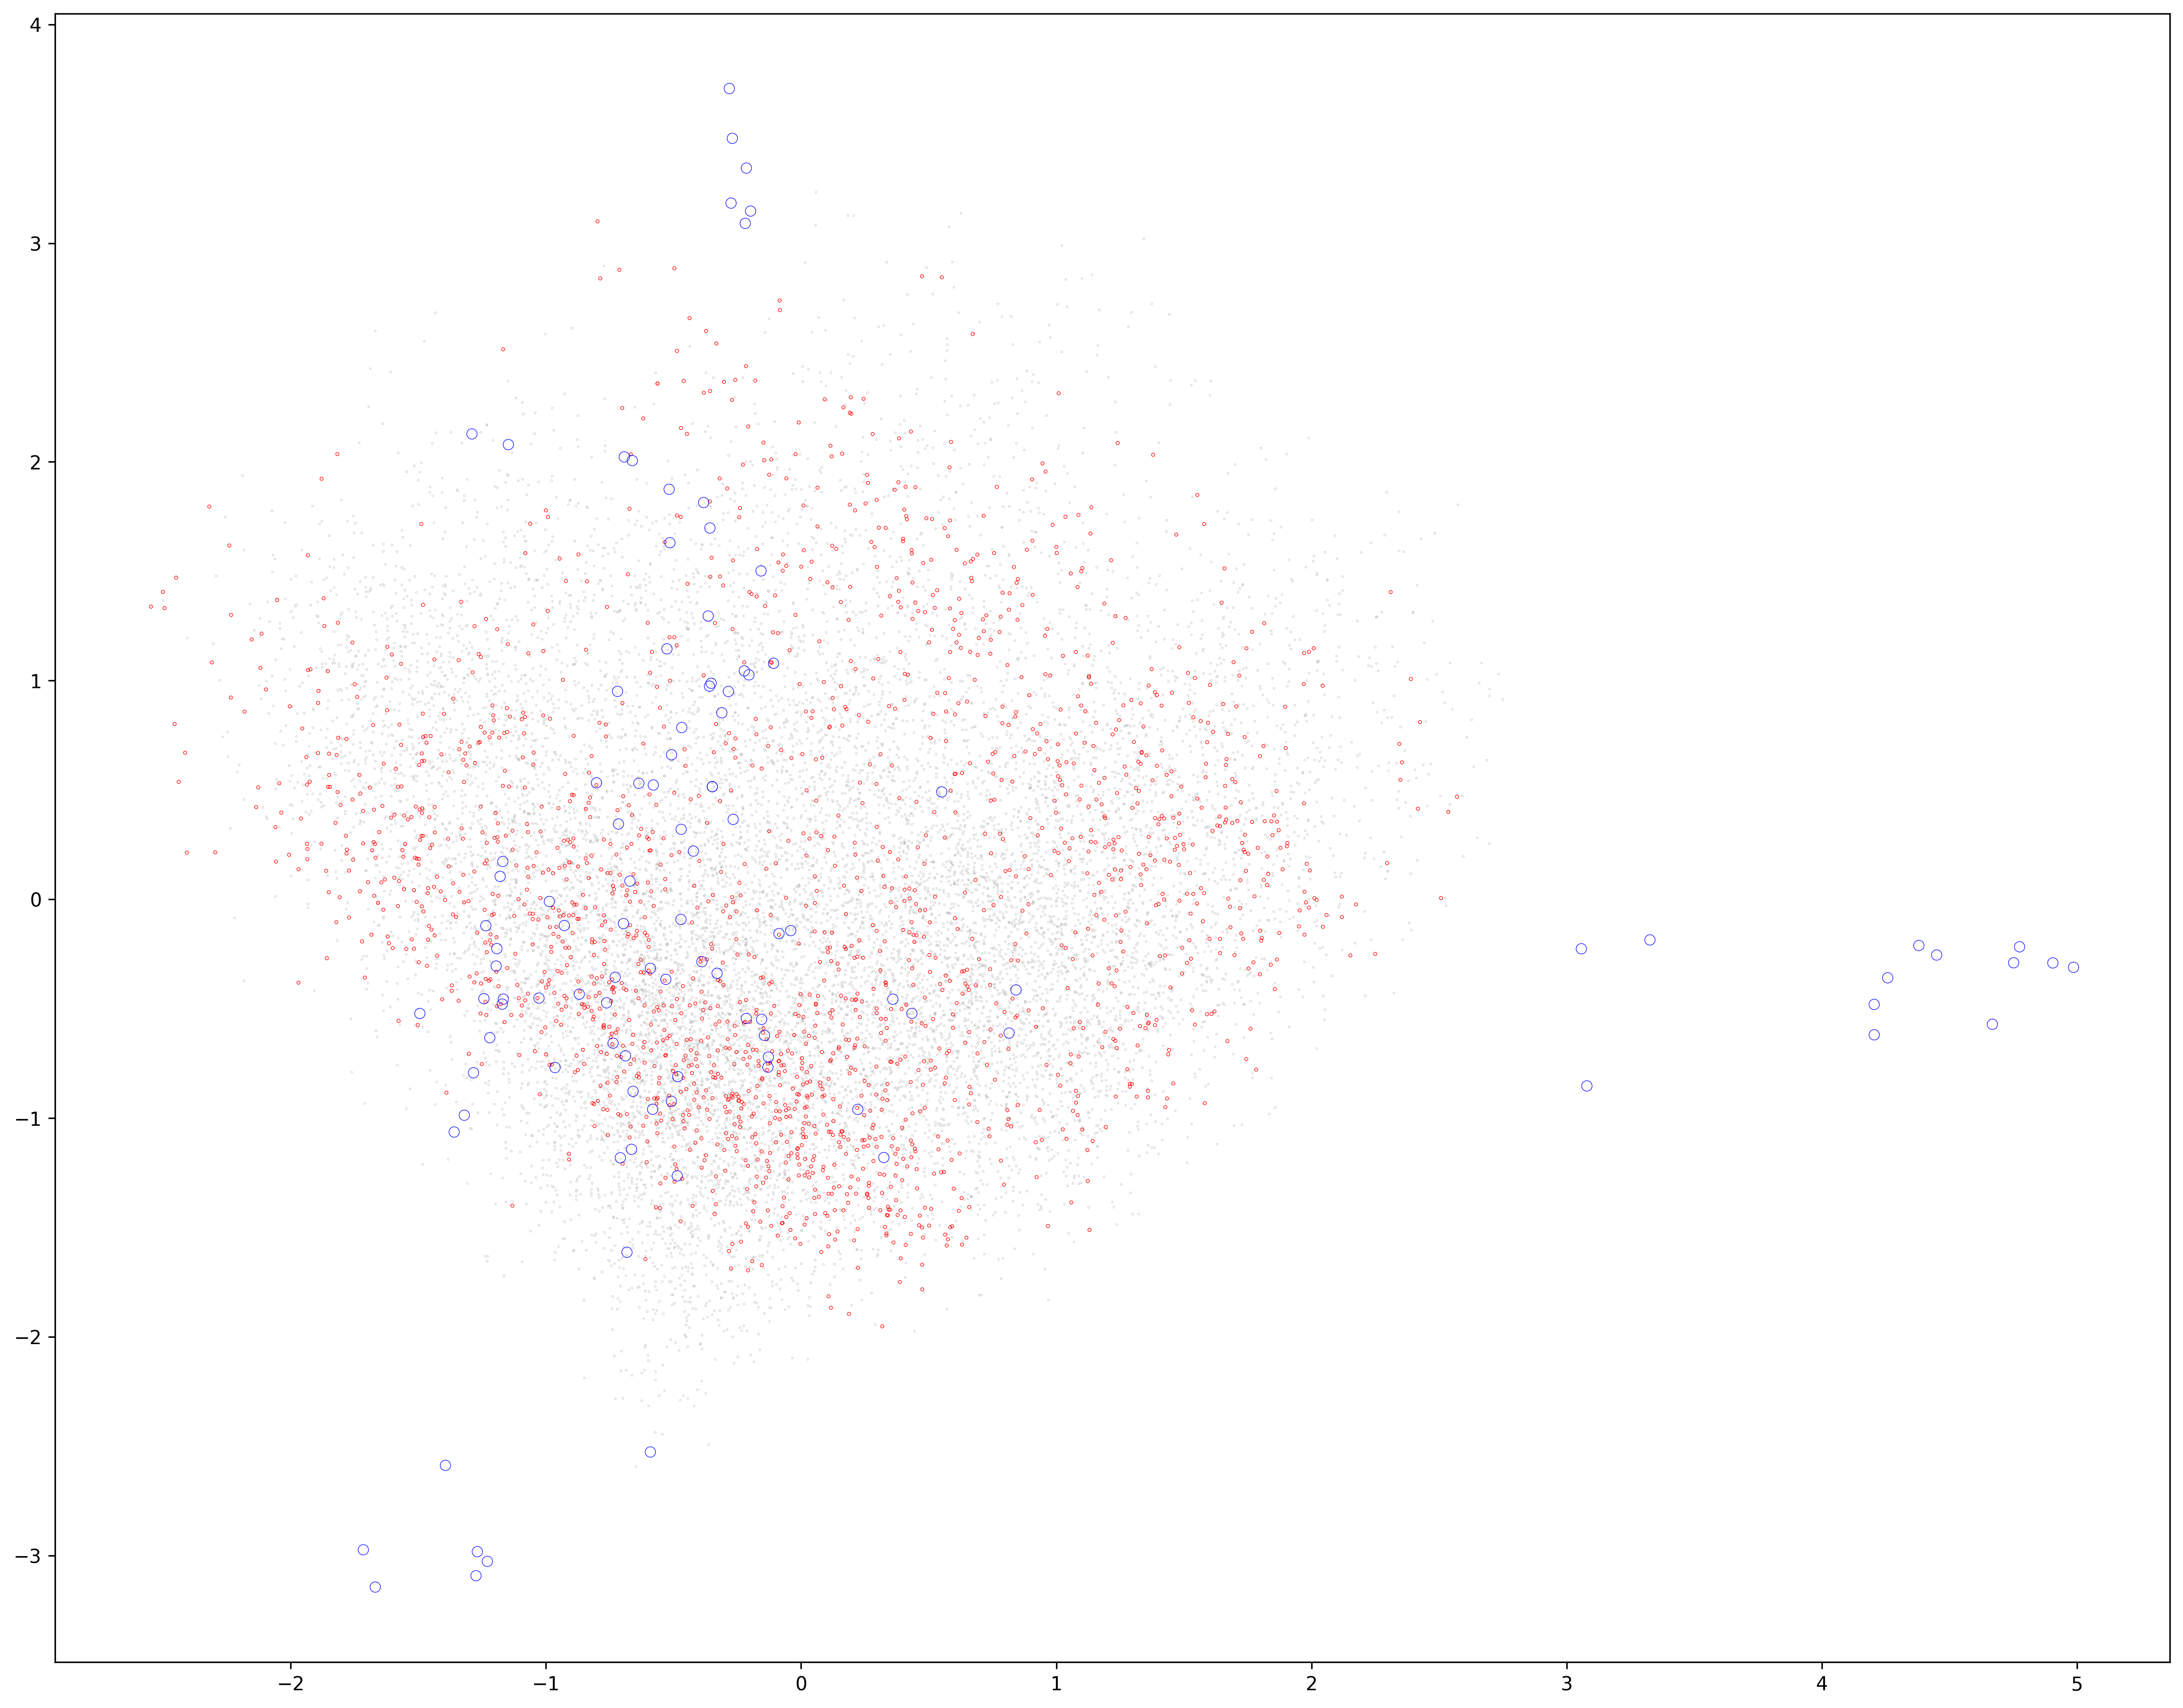

In [70]:
from matplotlib.pyplot import figure
figure(figsize=(20, 16), dpi=300)

plt.scatter(x = chemicalspace_inc[:, 0], y = chemicalspace_inc[:, 1], s=1, facecolors='none', edgecolors='gray', linewidths=0.1)
plt.scatter(x = chemicalspace_inac[:, 0], y = chemicalspace_inac[:, 1], s=3, facecolors='none', edgecolors='r', linewidths=0.3)
plt.scatter(x = chemicalspace_act[:, 0], y = chemicalspace_act[:, 1], s=30, facecolors='none', edgecolors='b', linewidths=0.3)

* We can see that inconclusive molecules are sparse above the chemical space and do not form any clusters. The same for the inactives (red circles), except for some small clusters inside the mass. 

* We can see that there are 3 active clusters. Anyway, they are in fact a little small one. For my surprise, there are active molecules remarkably close to inactive molecules, which is something that I did not expect.  

* It can be considered new active molecules to those inconclusive molecules near to some active molecule, where there aren't inactive molecules and its pChEMBL value is higher than the mean of the active molecules. 

There are approx. 25 molecules with active label that are forming clusters outside of the centric mass of molecules. Hopefully, our new selection of active molecules from the inconclusive pool will help. 

## Selection of new active molecules 

The selection of actives from the inconclusive ones is going to be carried out using the criteria: 

* At least 0.7 Tanimoto similarity 

* At maximum of 0.95, to ensure some diversity 

* Its activity needs to be bigger than the active molecule compared to 

* There cannot be an inactive molecule more similar than the closest active molecule. 

### Preparing the molecules used to compare

To distinguish from inconclusives from the inactive molecules, there will be only used those truly inactive molecules with a pChEMBL value lower than 4.5.

In [75]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_act]

# INACTIVE
inactives = df_inac['pChEMBL_Value'] <= 4.5
df_inac_filt = df_inac[inactives]
smiles_inac = df_inac_filt.values[:, 0]
fps_inac = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inac]

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
df_inc_filt = df_inc[pseudo_actives]
smiles_inc = df_inc_filt.values[:, 0]
fps_inc = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inc]

### Algoritm to select molecules with more chances to be active

In [83]:
from rdkit import DataStructs

new_positives_indices = []
for i, fp_active in enumerate(fps_act):
    print(f'Estamos en la molecula activa numero { i + 1 }')
    candidates_from_pseudoactives = []
    for e, fp_candidate in enumerate(fps_inc):
        tn = DataStructs.FingerprintSimilarity(fp_active, fp_candidate)
        similarity_diversity_criteria = (tn >= 0.7) & (tn <= 0.95)
        candidate_activity_criteria = df_inc_filt.values[:, 1][e] >= df_act.values[:, 1][i]
        
        if similarity_diversity_criteria and candidate_activity_criteria:
            # print(f'Tenemos un candidato')
            candidates_from_pseudoactives.append((fp_candidate, e, tn))

    for a, candidate in enumerate(candidates_from_pseudoactives):
        fp_candidate, e, tn_active = candidate
        candidate_act_similarity_criteria = True

        for u, fp_inactive in enumerate(fps_inac):
            tn_inac = DataStructs.FingerprintSimilarity(fp_inactive, fp_candidate)
            candidate_act_similarity_criteria = tn_active > tn_inac

            if not candidate_act_similarity_criteria:
                break

        if candidate_act_similarity_criteria:
            # print('Nueva molecula activa')
            new_positives_indices.append(e)



Estamos en la molecula activa numero 1
Estamos en la molecula activa numero 2
Estamos en la molecula activa numero 3
Estamos en la molecula activa numero 4
Estamos en la molecula activa numero 5
Estamos en la molecula activa numero 6
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Estamos en la molecula activa numero 7
Tenemos un candidato
Tenemos un candidato
Nueva molecula activa
Nueva molecula activa
Estamos en la molecula activa numero 8
Estamos en la molecula activa numero 9
Esta

## TODO
Same aproach to select new inactve molecules from the inconclusive pools. Since there are lot more inactive molecules covering the same places that inconclusives, from this aproach will raise much more inactive molecules.

In [1]:
# TODO

## Saving the molecules datasets

### Saving the new active molecules

In [90]:
# Delete duplicate molecules since the same inconclusive molecule can be near to two active molecules. 
values = list(set(new_positives_indices))

smiles_inc_to_postive = df_inc_filt.values[values, 0]
df_inc_to_postive = pd.DataFrame({'Smiles':smiles_inc_to_postive}).sample(frac=1).assign(is_active = 1)
df_inc_to_postive.to_csv('./procesed/inconclusives/new_positives.csv', index=False)

### Saving the active and inactive molecules

In [101]:
# ACTIVE
actives_final_df = df_act.sample(frac=1).assign(is_active = 1)[['Smiles', 'is_active']].reset_index(drop=True)
actives_final_df.to_csv('./procesed/actives/final_actives.csv', index=False)

# INACTIVE
inactives_final_df = df_inac.sample(frac=1).assign(is_active = 0)[['Smiles', 'is_active']].reset_index(drop=True)
inactives_final_df.to_csv('./procesed/inactives/final_inactives.csv', index=False)

In [4]:
import pandas as pd

# Dataset for training and testing preparation

## Reading the files

In [5]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives)} inactive molecules in the dataset')


There are 203 active molecules in the dataset
There are 4681 inactive molecules in the dataset


In [ ]:
# .sample(frac = 1) is for shuffle the data
df_concat = pd.concat([df_actives, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

## Spliting the dataset for training and teting with sklearn

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')

There are 4881 molecules in the dataset
There are 3904 molecules in training dataset
There are 977 molecules in test dataset


### Oversampling the training dataset 

At the end, I decided to not oversample the active molecules and consider the imbalance during the training in the loss function. 

In [10]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
df_active = df[active].sample(frac=2, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/training_ds.csv', index=False)

Ther are 161 different active molecules
Ther are 3743 different inactive molecules
Oversampling active ones
Ther are 322 different active molecules
Ther are 3743 different inactive molecules
 - - - - - - - - - - - - 


### Saving the test set

In [11]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/test_ds.csv', index=False)

Ther are 39 different active molecules
Ther are 938 different inactive molecules


### Creating and saving a dummy training set

In [12]:
df_actives = df[active]
num_actives = len(df_actives)

df_inactives = df[inactive].sample(num_actives)

# Concatening
df_dummy_training = pd.concat([df_actives, df_inactives]).sample(frac=1).sample(frac=1).sample(frac=1)
df_dummy_training.to_csv('./data_for_training_and_testing/dummy_training_ds.csv', index=False)

---

## Actives + Inconclusives + Decoys

Decoy molecules were generated with DUD-E to enhance the feature extraction from the molecules. As seen in this paper, this approach is used to make benchmark dataset, since this approach test the models in its performance to distinguish between active molecules from similar inactive molecules without bias. 

* Réau M, Langenfeld F, Zagury J-F, Lagarde N and Montes M (2018) Decoys Selection in Benchmarking Datasets: Overview and Perspectives. Front. Pharmacol. 9:11. doi: 10.3389/fphar.2018.00011

Decoys were generated from the active molecules.

In [15]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_decoys = pd.read_csv('./procesed/actives/decoys/decoy_final.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives) + len(df_decoys)} inactive molecules in the dataset')

There are 203 active molecules in the dataset
There are 5246 inactive molecules in the dataset


In [16]:
df_concat = pd.concat([df_actives, df_decoys, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

In [17]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')


There are 5446 molecules in the dataset
There are 4356 molecules in training dataset
There are 1090 molecules in test dataset


In [20]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
# NOT OVERSAMPLING
df_active = df[active].sample(frac=1, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print(' - - - - - - - - - - - - ')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/training_wdec_ds.csv', index=False)

Ther are 163 different active molecules
Ther are 4193 different inactive molecules
Oversampling active ones
Ther are 163 different active molecules
Ther are 4193 different inactive molecules
 - - - - - - - - - - - - 


In [19]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

#df['is_active'] = np.where(df['pChEMBL Value'] >= active_cutoff, 1, 0)
df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/test_wdec_ds.csv', index=False)

Ther are 37 different active molecules
Ther are 1053 different inactive molecules


# Training the model. 
A DNN is proposed first, but an GNN will be also implemented. The model was optimizated using Optuna.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install rdkit-pypi

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 48.6 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 52.7 MB/s 
     |████████████████████████████████| 149 kB 57.2 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8f389ceb3f9b559fe6be80208bfa9a1840762cfcb3b4df30d6db5e6457b63ad4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 20.6 MB 6.2 MB/s 


## DNN
Morganfp were generated using Rdkit and used as input. NN was constructed dinamicaly to find the best configuration using optuna. The best parameters were:


For mk
```
{
'batch_size': 111, 
'fp_size': 2000, 
'lr': 0.002222696558416456, 
'num_hidden_layers': 2, 
'seq_init_out': 3000, 
'dropout': 0.55
}
```

Device is: cuda
Epoch 0
loss 1.4376 | precision_score 0.0844 | matthews_corrcoef 0.1831 | accuracy 0.6687
loss 8.9271 | precision_score 0.4545 | matthews_corrcoef 0.2345 | accuracy 0.9651

Epoch 2
loss 0.1877 | precision_score 0.4278 | matthews_corrcoef 0.6304 | accuracy 0.9502
loss 0.7966 | precision_score 0.2542 | matthews_corrcoef 0.4239 | accuracy 0.9128

Epoch 4
loss 0.0709 | precision_score 0.7352 | matthews_corrcoef 0.8459 | accuracy 0.9862
loss 1.1152 | precision_score 0.5490 | matthews_corrcoef 0.6302 | accuracy 0.9706

Epoch 6
loss 0.0259 | precision_score 0.9056 | matthews_corrcoef 0.9497 | accuracy 0.9961
loss 1.0889 | precision_score 0.5957 | matthews_corrcoef 0.6586 | accuracy 0.9743

Epoch 8
loss 0.0242 | precision_score 0.8859 | matthews_corrcoef 0.9388 | accuracy 0.9952
loss 1.4228 | precision_score 0.5778 | matthews_corrcoef 0.6232 | accuracy 0.9725

Epoch 10
loss 0.0129 | precision_score 0.9314 | matthews_corrcoef 0.9637 | accuracy 0.9972
loss 1.4284 | precision_scor

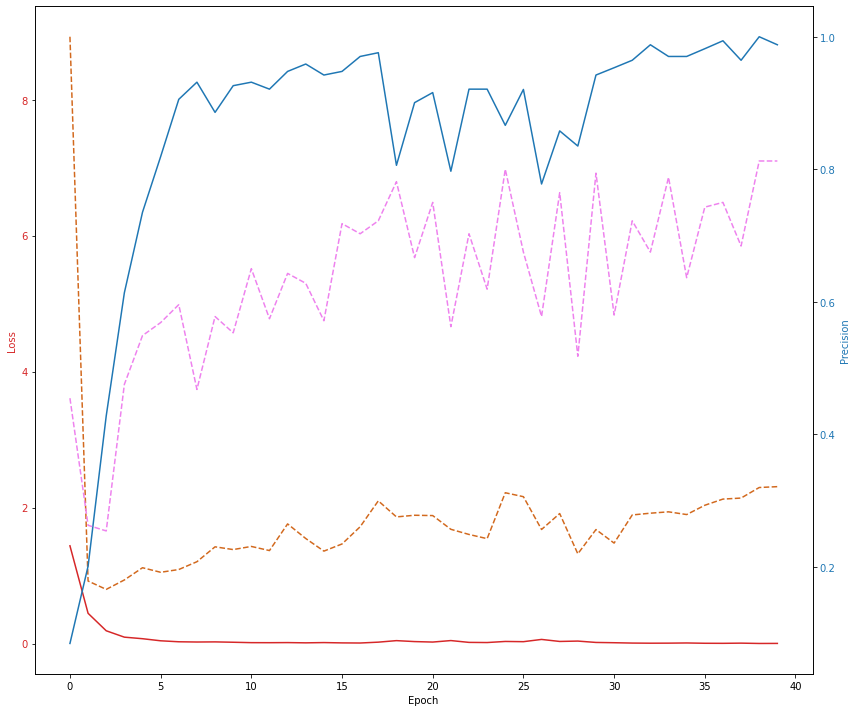

In [ ]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

class fpDataset(Dataset):
    def __init__(self, file_name, fp_size):
        self.data = pd.read_csv(file_name).values
        self.fp_size = fp_size
        self.postives = np.sum(self.data[:, 1])
        print(f'The dataset contains {self.data} molecules with a total of {self.positives} active molecules')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles, y = self.data[idx, :]
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=2, nBits=self.fp_size)
        x = np.array(fp, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        return x, y


class fpModel(nn.Module):
    def __init__(self, num_hidden_layers, fp_size, seq_init_out, dropout):
        super(fpModel, self).__init__()
        self.drop = torch.nn.Dropout(p=dropout)
        self.seq_init = nn.Sequential(
            nn.Linear(fp_size, seq_init_out),
            nn.Dropout(p=dropout),
            nn.ReLU(),
        )

        self.middle_module_list = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.middle_module_list.append(
                nn.Linear(seq_init_out, seq_init_out))
            self.middle_module_list.append(
                nn.BatchNorm1d(num_features=seq_init_out))
            self.middle_module_list.append(nn.ReLU())
            self.middle_module_list.append(self.drop)

        self.middle_module = nn.Sequential(*self.middle_module_list)

        self.out_module = nn.Sequential(
            nn.Linear(seq_init_out, 1),
        )

    def forward(self, x):
        x = self.seq_init(x)
        x = self.middle_module(x)
        x = self.out_module(x)

        return x


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, y_target, criterion):
    model.eval()

    h = model(x)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for x, y_target in dataloader:
        x, y_target = x.to(DEVICE), y_target.to(DEVICE)

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])

        if e % 2 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    return test_precision_score, (train_metrics, test_metrics)


# OPTUNA PART
# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout):
    model = fpModel(num_hidden_layers, fp_size, seq_init_out, dropout)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

# TODO: This can be refactorized to delete this function
def get_model_criterion_optimizer_for_optuna(trial, weight, fp_size):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 12, step=2)
    seq_init_out = trial.suggest_int('seq_init_out', 1000, 3000, step=500)
    dropout = trial.suggest_float("dropout", 0.4, 0.8, step=0.05)
    return get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=True):
    train_dataset = fpDataset(file_name, fp_size=fp_size)
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle)
    weight = len(train_dataset) / train_dataset.postives
    weight = torch.Tensor([weight])
    return train_dataloader, weight



# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, fp_size, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight, fp_size)

    return model, criterion, optimizer, dataloader

# Best parameters. Some were changed since in training did not work to well


# Data
if __name__ == '__main__':
    batch_size_train = 120
    batch_size_test = 40
    fp_size = 2000

    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    train_dataloader, weight = get_dataset_and_weight(
        train_file_name, fp_size, batch_size_train, shuffle=True)

    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size_test, shuffle=False)

    num_hidden_layers = 2
    seq_init_out = 3000
    dropout = 0.55
    lr = 0.0005222696558416456
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 40
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    #AX1
    fig, ax1 = plt.subplots(figsize=(12,10))
    #figure(figsize=(18, 16), dpi=300)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Loss
    t = range(EPOCHS)
    ax1.plot(t, train_total_loss, color='tab:red')
    ax1.plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # AX2
    # Presicion
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Precision', color='tab:blue')  
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(t, train_precision_score, color='tab:blue')
    ax2.plot(t, test_precision_score, color='violet', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


The dataset overfits to fast in epoch 3-4 but presicion continue increasing until 0.8. Also the matthews_corrcoef increase, meaning that the model is learning.

# Optuna

In [ ]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState


## Optimization for DNN

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

def objective_fp(trial):

    EPOCHS = 12
    batch_size = trial.suggest_int('batch_size', 111, 511, step=100)
    fp_size = trial.suggest_int('fp_size', 1000, 2000, step=500)

    # Training
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_mk.csv'
    model, criterion, optimizer, train_dataloader = get_all_optuna(
        trial, fp_size, file_name, batch_size=batch_size, shuffle=True)
    # Testing
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv'
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size, shuffle=False)

    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    test_precision_score, _ = training_init(
        EPOCHS, model, [train_dataloader, test_dataloader], criterion, optimizer)

    return test_precision_score

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


## Optimization for GNN

Code taken from the DeepChem book 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [ ]:
# GPU version
!pip install tqdm
!pip install tensorflow~=2.4
!pip install deepchem

     |████████████████████████████████| 552 kB 4.2 MB/s 


In [ ]:
from rdkit.Chem import AllChem
import pandas as pd

# path_dummy = './data_for_training_and_testing/training_ds.csv'
# df = pd.read_csv(path_dummy)

import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

To be honest, I dont get much of the code from the book, but i will try any way since it is easy to implement and tune with optuna. Also, I've implemented a GNN with PyG by my own, but I still have to merge the code with this notebook ant adapt it to hypterparameter tunning with optuna, so it is a TODO. There is a preview code but is not finished.

In [ ]:
'''
dropout: float = 0.0, 
batch_size: int = 100, 
graph_conv_layers: List[int] = [64, 64], 
dense_layer_size: int = 128, 
number_atom_features: int = 75
'''
# n_tasks: int, 
# mode: str = 'classification', 
# n_classes: int = 2, 
# batch_normalize: bool = True

def generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features):
    model = GraphConvModel(1, dropout = dropout, batch_size=batch_size, graph_conv_layers=[graph_conv_layers,graph_conv_layers], dense_layer_size=dense_layer_size, number_atom_features=number_atom_features, mode='classification', model_dir="./model_dir")
    return model


def training(trial, cv_folds, dataset_file):

    # Model parameters
    dropout = trial.suggest_float("dropout", 0.4, 0.7, step=0.05)
    batch_size = trial.suggest_int('batch_size', 100, 200, step=100)
    graph_conv_layers = trial.suggest_int('graph_conv_layers', 32, 256, step=32)
    dense_layer_size = trial.suggest_int('dense_layer_size', 10, 510, step=100)
    number_atom_features = trial.suggest_int('number_atom_features', 40, 900, step=10)

    tasks = ["is_active"]
    featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks, feature_field="Smiles", featurizer=featurizer)
    dataset = loader.create_dataset(dataset_file, shard_size=8192)

    splitter = dc.splits.RandomSplitter()
    metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

    training_score_list = []
    validation_score_list = []
    transformers = []

    for i in tqdm(range(0,cv_folds)):
        model = generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features)
        train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
        model.fit(train_dataset)
        train_scores = model.evaluate(train_dataset, metrics, transformers)
        training_score_list.append(train_scores["mean-matthews_corrcoef"])
        validation_scores = model.evaluate(valid_dataset, metrics, transformers)
        validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
    
    print(training_score_list)
    print(validation_score_list)

    return max(validation_score_list), [training_score_list, validation_score_list]




## Optuna optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def objective_fp(trial):

    cv_folds = 5
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv'

    # Training
    matthews_corrcoef, _ = training(trial, cv_folds, file_name)

    return matthews_corrcoef

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



[I 2021-11-21 21:55:34,758] A new study created in memory with name: no-name-456abf6d-4c4e-4aa6-9ecb-671f77231a2f


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:02:21,039] Trial 0 finished with value: 0.3666557420110231 and parameters: {'dropout': 0.4, 'batch_size': 200, 'graph_conv_layers': 224, 'dense_layer_size': 110, 'number_atom_features': 580}. Best is trial 0 with value: 0.3666557420110231.


[0.31142327293666333, 0.3252938781556216, 0.0887806743234052, 0.3820428730342298, 0.3512757756433789]
[0.09909432385056663, 0.2458823949482132, 0.010929536002687376, 0.1639456653932076, 0.3666557420110231]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:08:32,020] Trial 1 finished with value: 0.5387729475023668 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 160, 'dense_layer_size': 310, 'number_atom_features': 710}. Best is trial 1 with value: 0.5387729475023668.


[0.4381188739990235, 0.42813393534625765, 0.4499707172797226, 0.3707002271803531, 0.43862938157429837]
[0.4730739101462069, 0.4114989568638858, 0.20087210141148906, 0.15153368870560166, 0.5387729475023668]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:12:53,738] Trial 2 finished with value: 0.6185326925533262 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 64, 'dense_layer_size': 310, 'number_atom_features': 430}. Best is trial 2 with value: 0.6185326925533262.


[0.35132724708808594, 0.41555356147932365, -0.0033091562315908287, 0.3999407869998277, 0.25645365298273365]
[0.0, 0.3699768545282051, -0.011420308290053941, 0.6185326925533262, 0.0]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:18:59,032] Trial 3 finished with value: 0.39612293317854486 and parameters: {'dropout': 0.6000000000000001, 'batch_size': 100, 'graph_conv_layers': 128, 'dense_layer_size': 410, 'number_atom_features': 760}. Best is trial 2 with value: 0.6185326925533262.


[0.26716876810574836, 0.3227950172266563, 0.17563882284663118, 0.3005377654854667, 0.10130931090312363]
[0.10449267622589367, 0.39612293317854486, 0.16245952444715636, 0.3466084835602096, 0.29960790893583633]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:24:37,097] Trial 4 finished with value: 0.46015041847250016 and parameters: {'dropout': 0.5, 'batch_size': 200, 'graph_conv_layers': 128, 'dense_layer_size': 310, 'number_atom_features': 560}. Best is trial 2 with value: 0.6185326925533262.


[0.008498171981341292, 0.354538667303903, 0.3218216914001759, 0.14107840495777685, 0.275491715588087]
[0.0, 0.2660799204900621, 0.46015041847250016, 0.22916733139243078, 0.24875203627196815]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:30:34,510] Trial 5 finished with value: 0.30462519936204147 and parameters: {'dropout': 0.7, 'batch_size': 100, 'graph_conv_layers': 96, 'dense_layer_size': 510, 'number_atom_features': 130}. Best is trial 2 with value: 0.6185326925533262.


[0.11068179795142556, 0.07760079476983604, -0.006754278753035485, 0.17700900435948627, 0.1984115758924944]
[0.035752028795694994, 0.04492045598139898, 0.10489250989106286, 0.288744856381007, 0.30462519936204147]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:36:55,785] Trial 6 finished with value: 0.3491605795718848 and parameters: {'dropout': 0.65, 'batch_size': 200, 'graph_conv_layers': 96, 'dense_layer_size': 510, 'number_atom_features': 560}. Best is trial 2 with value: 0.6185326925533262.


[0.08834770155009081, 0.07519972754436026, 0.2017417406613238, 0.19151064231232537, 0.15866937328113306]
[0.08048381856548995, 0.10369061564714453, 0.19276221332275825, 0.3491605795718848, 0.22026141230982696]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:42:35,088] Trial 7 finished with value: 0.22958475325003155 and parameters: {'dropout': 0.55, 'batch_size': 200, 'graph_conv_layers': 128, 'dense_layer_size': 210, 'number_atom_features': 740}. Best is trial 2 with value: 0.6185326925533262.


[0.3508706340196287, 0.057058030122811146, 0.43077493702220787, 0.13654079743409328, 0.3197586846128415]
[0.22958475325003155, 0.05960270128742373, 0.05900199116224357, 0.2125378436027871, 0.18715773373420289]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:48:02,475] Trial 8 finished with value: 0.22540204719841214 and parameters: {'dropout': 0.65, 'batch_size': 100, 'graph_conv_layers': 192, 'dense_layer_size': 10, 'number_atom_features': 550}. Best is trial 2 with value: 0.6185326925533262.


[0.06903546416686789, 0.014909171990204504, 0.21946027896143042, 0.15776680307044305, 0.007484811885651197]
[0.015477736296523673, -0.01090549219462522, 0.15952200078742032, 0.22540204719841214, -0.030641885618414372]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:53:05,333] Trial 9 finished with value: 0.4372653339429707 and parameters: {'dropout': 0.5, 'batch_size': 100, 'graph_conv_layers': 96, 'dense_layer_size': 310, 'number_atom_features': 730}. Best is trial 2 with value: 0.6185326925533262.


[0.45355406440562435, 0.303386250191383, 0.2752526235863547, 0.20321001526131685, 0.1973015391644003]
[0.3830291508053092, 0.2360293298714918, 0.4372653339429707, 0.0, 0.3017758862777668]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:56:16,768] Trial 10 finished with value: 0.507957567321401 and parameters: {'dropout': 0.4, 'batch_size': 100, 'graph_conv_layers': 32, 'dense_layer_size': 110, 'number_atom_features': 280}. Best is trial 2 with value: 0.6185326925533262.


[0.4070783695974446, 0.4384387178764624, 0.37594467402005854, 0.3747863117459623, 0.11105551162848569]
[-0.013969968905677815, 0.34924682726800554, 0.507957567321401, 0.47389255336829644, 0.3238656100986309]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:00:08,869] Trial 11 finished with value: 0.5321268887870542 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 32, 'dense_layer_size': 310, 'number_atom_features': 340}. Best is trial 2 with value: 0.6185326925533262.


[0.20868650540319877, 0.3147615421641707, 0.32065536239375547, 0.11399585056305109, 0.38943356804350104]
[0.2310506847028597, -0.008405370549189543, 0.5321268887870542, 0.2632373918468618, 0.40111469009653516]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:07:59,106] Trial 12 finished with value: 0.43745975774567164 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 192, 'dense_layer_size': 410, 'number_atom_features': 900}. Best is trial 2 with value: 0.6185326925533262.


[0.383211386017896, 0.42861825685637694, 0.35822325662741417, 0.17818019268152377, 0.26485190787724744]
[0.1438044719065396, 0.43745975774567164, 0.3782146173209342, 0.15676867904733227, 0.19248403378988388]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:18:29,499] Trial 13 finished with value: 0.48121456943911267 and parameters: {'dropout': 0.5, 'batch_size': 100, 'graph_conv_layers': 256, 'dense_layer_size': 210, 'number_atom_features': 370}. Best is trial 2 with value: 0.6185326925533262.


[0.3046077842707793, 0.3325488161480739, 0.2471849681381318, 0.35950765596241246, 0.3142389001169456]
[0.34696035209761994, 0.2071285688306965, 0.134219142285382, 0.48121456943911267, 0.3601174886325737]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:24:09,975] Trial 14 finished with value: 0.5220063697216698 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 64, 'dense_layer_size': 410, 'number_atom_features': 430}. Best is trial 2 with value: 0.6185326925533262.


[0.46342236913019796, 0.3739574533648126, 0.39298872737785145, 0.2633161622340621, 0.42158138291554753]
[0.5220063697216698, 0.15858301525563182, 0.46802924178308264, 0.21866890943621362, 0.3129393463320946]


  0%|          | 0/5 [00:00<?, ?it/s]